### 합성곱 층
* 구현

In [15]:
import numpy as np
from sklearn.datasets import load_sample_image
import tensorflow as tf
from tensorflow import keras

In [2]:
china = load_sample_image('china.jpg') / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape # (2, 427, 640, 3)

In [3]:
images.shape

(2, 427, 640, 3)

In [4]:
# 2개의 필터 만듦
filters = np.zeros(shape = (7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # 수직선
filters[3, :, :, 1] = 1 # 수평선

In [6]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

In [8]:
outputs.shape # 흑백

TensorShape([2, 427, 640, 2])

In [10]:
china.shape

(427, 640, 3)

In [11]:
def crop(images) :
    return images[150:220, 130:250]

In [14]:
crop(outputs[0, :, :]).shape

TensorShape([70, 120, 2])

In [16]:
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                          padding='SAME', activation='relu', input_shape=outputs.shape)

In [17]:
conv_outputs = conv(images)
conv_outputs.shape # 배치 크기(2개의 이미지), 높이, 너비, 채널(2개의 필터)

TensorShape([2, 427, 640, 2])

In [18]:
conv.set_weights([filters, np.zeros(2)])

In [21]:
# VAILD VS SAME 패딩
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [22]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [23]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

# SAME 패딩 = manual_same_padding 사용해 수동으로 패딩하고, VALID 패딩 사용하는 것과 동일

In [24]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 합니다.
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사합니다.
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

### 풀링 층

In [25]:
# 최대 풀링
# 불변성, 많은 정보 잃음 (의미 없는 것은 모두 제거, 가장 큰 특징만 유지)
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [26]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

In [29]:
print(cropped_images.shape)
print(output.shape)

(2, 70, 120, 3)
(2, 35, 60, 3)


In [30]:
# 평균 풀링
# 정보손실 적지만, 성능 낮음
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)
print(output_avg.shape)

(2, 35, 60, 3)


In [32]:
# 풀링은 깊이 차원(공간차원 X) -> tensorflow 저수준 딥러닝 API 사용
output = tf.nn.max_pool(images, ksize = (1, 1, 1, 3),
                       strides = (1, 1, 1, 3),
                       padding = 'VALID')

depth_pool = keras.layers.Lambda(
                lambda X : tf.nn.max_pool(X, ksize=(1,1,1,3), strides=(1,1,1,3),
                                         padding='VALID'))

In [36]:
# 전역 평균 풀링
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [37]:
global_avg_pool = keras.layers.Lambda(lambda X : tf.reduce_mean(X, axis=[1, 2]))

### CNN 구조

In [38]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [39]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [40]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 444s 256ms/step - loss: 0.7209 - accuracy: 0.7487 - val_loss: 0.4078 - val_accuracy: 0.8588
Epoch 2/10
1719/1719 [==============================] - 441s 257ms/step - loss: 0.4417 - accuracy: 0.8488 - val_loss: 0.3333 - val_accuracy: 0.8734
Epoch 3/10
1719/1719 [==============================] - 466s 271ms/step - loss: 0.3705 - accuracy: 0.8742 - val_loss: 0.3110 - val_accuracy: 0.8838
Epoch 4/10
1719/1719 [==============================] - 488s 284ms/step - loss: 0.3421 - accuracy: 0.8853 - val_loss: 0.3030 - val_accuracy: 0.8890
Epoch 5/10
1719/1719 [==============================] - 577s 335ms/step - loss: 0.3169 - accuracy: 0.8918 - val_loss: 0.2927 - val_accuracy: 0.9008
Epoch 6/10
1719/1719 [==============================] - 524s 305ms/step - loss: 0.2935 - accuracy: 0.8991 - val_loss: 0.2841 - val_accuracy: 0.8958
Epoch 7/10
1719/1719 [==============================] - 533s 310ms/step - loss: 0.2846 - accuracy: 0.9039 - val_

1. LeNet-5
2. AlexNet - 처음으로 풀링 층 쌓지 않고, 바로 합성곱 층끼리 쌓음
3. GoogleLeNet - 인셉션 모듈(1X1 필터 사용한 합성곱 층)
    * 입력보다 더 적은 특성 맵 출력하는 병목 층 역할
4. VGGNet
    * 2-3개의 합성곱 층 뒤에 풀링 층 나오고, 다시 2-3개 합성곱층과 풀링 층 등장
    * 마지막 밀집 네트워크는 2개의 은닉층과 출력층으로 이루어짐
    * 3X3 필터만 사용
5. ResNet - 스킵연결로, 어떤 층에 주입되는 신호가 상위 층의 출력에도 더해짐
    * 풀링층 없음
    * 배치 정규화(BN) + ReLU + 3X3 커널 + 스트라이드 1, SAME 패딩 의 두 개의 합성곱 층
6. Xception - 깊이별 분리 합성곱 층
    * 공간 패턴과 채널 사이 패턴을 분리하여 모델링
    * 첫 번째 부분은 하나의 공간 필터릴 각 입력 특성 맵에 적용
    * 두 번째 부분은 채널 사이 패턴만 조사 - 1X1 필터 사용한 일반적인 합성곱 층
    * 두 개의 일반 합성곱 층 + 34개의 분리 합성곱
7. SENet
    * 인셉션 모듈이나 모든 잔차 유닛에 SE 블록 추가하여 성능 향상
    * SE블록 = 전역 평균 풀링 + ReLU 사용하는 밀집 은닉층 + 시그모이드 사용하는 밀집 출력 층
    
    
### 케라스 사용해 ResNet-34 CNN 구현하기

In [41]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

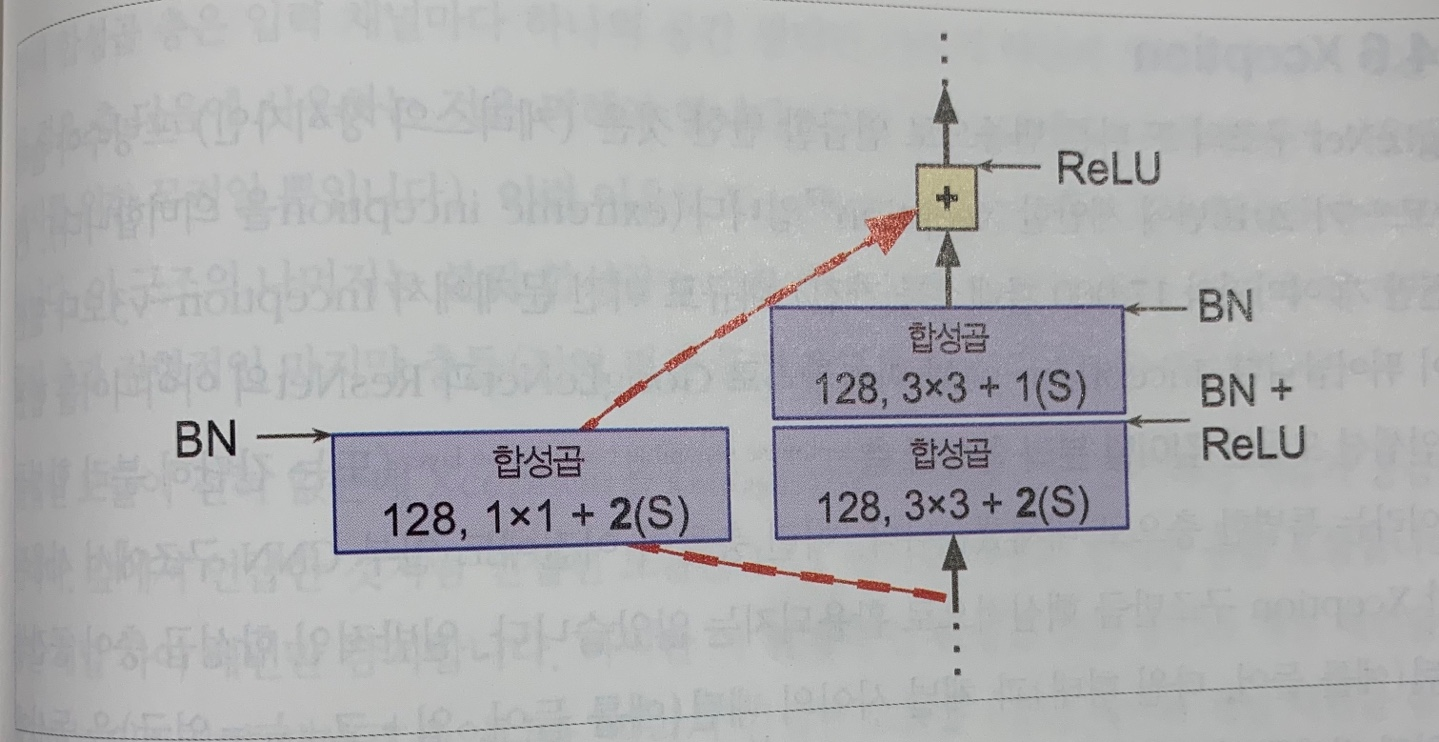

In [43]:
class ResidualUnit(keras.layers.Layer) :
    def __init__(self, filters, strides=1, activation = 'relu', **kwargs) :
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        # 위의 그림의 오른쪽 모듈
        self.main_layers = [
                DefaultConv2D(filters, strides=strides),
                keras.layers.BatchNormalization(),
                self.activation,
                DefaultConv2D(filters),
                keras.layers.BatchNormalization()
        ]
        self.skip_layers = [] # 위의 그림의 왼쪽 모듈
        
        if strides > 1 :
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
            
    def call(self, inputs) :
        Z = inputs
        for layer in self.main_layers : 
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers :
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [44]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                       input_shape = [224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='SAME'))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3 :
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

### 케라스에서 제공하는 사전훈련된 모델 사용하기
* GoogLeNet이나 ResNet 같은 표준 모델은 직접 구현할 필요 없다.
* keras.applications 패키지에 준비

In [46]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 7s 0us/step


In [47]:
images_resized = tf.image.resize(images, [224, 224])
images_resized.shape

TensorShape([2, 224, 224, 3])

In [57]:
# 모델마다 이미지 전처리
#inputs = keras.applications.resnet50.ResNet50.preprocess_input(images_resized * 255)
# 앞에서 0~1사이로 바꾸었기에, 0~255 사이로 변경
inputs=images_resized*255

In [58]:
y_proba = model.predict(inputs)

1/1 [==============================] - 2s 2s/step


In [59]:
# 최상위 K개의 예측을 클래스 이름과 예측 클래스의 추정 확률 출력
top_K = keras.applications.resnet50.decode_predictions(y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, i in top_K[image_index]: # 클래스 아이디, 이름, 확률
        print("  {} - {:12s} {:.2f}%".format(class_id, name, i * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
  n02825657 - bell_cote    48.03%
  n02843684 - birdhouse    8.28%
  n03877845 - palace       3.86%

Image #1
  n02206856 - bee          34.63%
  n03530642 - honeycomb    24.89%
  n04522168 - vase         12.11%



### 사전훈련된 모델을 사용한 전이 학습

In [60]:
import tensorflow_datasets as tfds

In [61]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True) # with_info : 데이터셋 정보
dataset_size = info.splits['train'].num_examples # 3670
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes # 5

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\knuyh\tensorflow_datasets\tf_flowers\incomplete.I97ZVD_3.0.1\tf_flowers-train.tfrecord*...:…

Dataset tf_flowers downloaded and prepared to C:\Users\knuyh\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [63]:
# train set만 있어 나눠야함
test_set, val_set, train_set = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [64]:
# 전처리
def preprocess(image, label) :
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [65]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [66]:
batch_size = 32
train_set = train_set.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
val_set = val_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [67]:
# Xception
base_model = keras.applications.xception.Xception(weights='imagenet', include_top = False) # 네트워크 최상층의 전역 평균 풀링과 밀칩 출력 층 제외, 새롭게 추가
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation = 'softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs = output)

83683744/83683744 [==============================] - 5s 0us/step


In [68]:
for index, layer in enumerate(base_model.layers) :
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [69]:
# 훈련 초기에는 사전훈련된 층의 가중치 동결
for layer in base_model.layers :
    layer.trainable=False

In [72]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data = val_set, validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 440s 5s/step - loss: 0.9644 - accuracy: 0.8176 - val_loss: 0.9102 - val_accuracy: 0.8548
Epoch 2/5
86/86 [==============================] - 375s 4s/step - loss: 0.5501 - accuracy: 0.8884 - val_loss: 0.8602 - val_accuracy: 0.8658
Epoch 3/5
86/86 [==============================] - 367s 4s/step - loss: 0.2932 - accuracy: 0.9288 - val_loss: 0.7772 - val_accuracy: 0.8621
Epoch 4/5
86/86 [==============================] - 379s 4s/step - loss: 0.2128 - accuracy: 0.9379 - val_loss: 0.6571 - val_accuracy: 0.8676
Epoch 5/5
86/86 [==============================] - 445s 5s/step - loss: 0.1531 - accuracy: 0.9484 - val_loss: 0.6232 - val_accuracy: 0.8585


In [74]:
# 모든 층 동결 해제 -> 컴파일 필수
for layer in base_model.layers :
    layer.trainable = True

# 사전훈련된 가중치 훼손 방지를 위한 작은 학습률
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=val_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 1784s 21s/step - loss: 0.3343 - accuracy: 0.8863 - val_loss: 0.6778 - val_accuracy: 0.8309
Epoch 2/40
86/86 [==============================] - 1585s 18s/step - loss: 0.1150 - accuracy: 0.9688 - val_loss: 0.2445 - val_accuracy: 0.9118
Epoch 3/40
31/86 [=========>....................] - ETA: 18:17 - loss: 0.0814 - accuracy: 0.9778

KeyboardInterrupt: 

### 분류와 위치 추정
* 바운딩박스 예측 - 수평, 수직, 높이, 너비

In [75]:
# 전역 평균 풀링 층 위에 네 개의 유닛을 가진 두 번째 밀집 출력 층 추가하고, MSE 손실 사용
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

In [76]:
model.compile(loss=['sparse_categorical_crossentropy', 'mse'],
             loss_weights=[0.8, 0.2], optimizer=optimizer, metrics=['accuracy'])

In [77]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [78]:
fake_train_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [80]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 125s 22s/step - loss: 1.3958 - dense_5_loss: 1.6572 - dense_6_loss: 0.3501 - dense_5_accuracy: 0.1813 - dense_6_accuracy: 0.2375
Epoch 2/2
5/5 [==============================] - 101s 21s/step - loss: 1.2436 - dense_5_loss: 1.5030 - dense_6_loss: 0.2060 - dense_5_accuracy: 0.2562 - dense_6_accuracy: 0.2188


* 바운딩 박스 지표 IoU : tf.keras.metrics.MeanIoU

### 객체 탐지
*  조금씩 다른 위치에서 동일한 물체 여러 번 감지하는 불필요한 바운딩 박스 제거하기 위한 사후처리 -> NMS(non-max suppression)
    * 존재여부 이진 시그모이드 사용하여 존재여부 점수가 임계값 이하인 바운딩 박스 삭제
    * 존재여부 점수가 가장 높은 바운딩 박스와 많이 중첩된 박스 제거
* 완전 합성곱 신경망 (FCN) : 전체 이미지를 딱 한번 처리하여 8X8 크기의 배열 출력
* YOLO
* 평가 지표 : mAP

### 시맨틱 분할
* 각 픽셀이 속한 객체의 클래스로 분류
* 클래스가 같은 물체는 구별되지 않음
* 이미지가 일반 CNN 통과할 때 점진적으로 위치 정보를 잃는 점이 어려움(1이상의 stride 사용하는 층 때문)  
-> 사전훈련된 CNN을 FCN으로 변환
* 마지막 층이 입력 이미지보다 32배나 작은 특성 맵 출력하여 듬성듬성
* 따라서 해상도를 32배로 늘리는 업샘플링 층 추가 - 전치 합성곱 층 사용 : tf.keras.Conv2DTranspose

In [81]:
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])